<a href="https://colab.research.google.com/github/golark/gpt_primer/blob/main/iris_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from datasets import load_dataset

dataset = load_dataset("scikit-learn/iris")
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Iris.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/150 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species'],
        num_rows: 150
    })
})


In [3]:
df = dataset['train'].to_pandas()
print(f'species: {df["Species"].unique()}')

df.head()

species: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
import torch
import torch.nn as nn

class SimpleMLP(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.net = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )

    def forward(self, x):
        return self.net(x)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Extract features and target
features = df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']].values
labels = df['Species'].values

# Encode labels to integers
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# Split dataset into train and test (let's use 80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(
    features, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

# Convert to torch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [6]:
model = SimpleMLP()
f_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def accuracy(model, x, y):
    model.eval()
    with torch.no_grad():
        logits = model(x)
        preds = logits.argmax(dim=1)
        return (preds == y).float().mean().item()

losses = []
acc = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()

    # forward ------------>
    logits = model(x_train)        # shape: (N, 3)
    loss = f_loss(logits, y_train) # y shape: (N,)

    # <----------- backward
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        acc.append(accuracy(model, x_test, y_test))
        losses.append(loss.item())

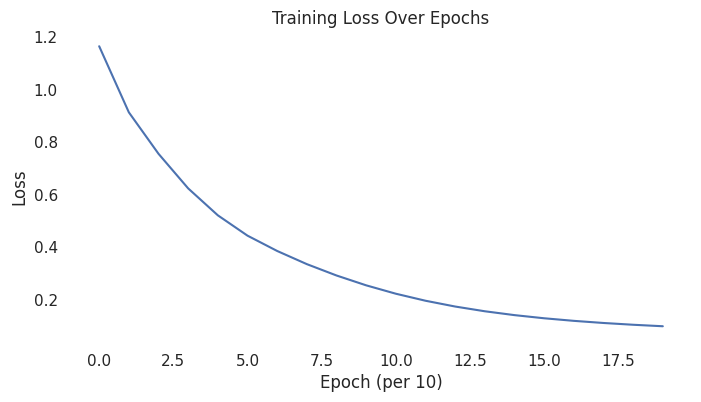

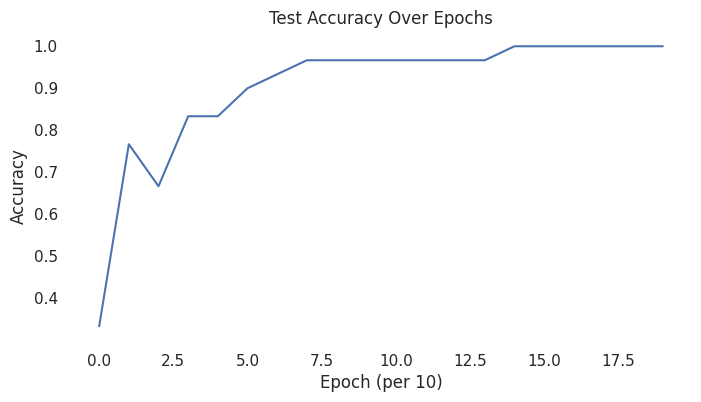

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", rc={"axes.facecolor": (0, 0, 0, 0)})

# Plot Loss
plt.figure(figsize=(8, 4), facecolor="none")  # transparent figure background
sns.lineplot(x=range(len(losses)), y=losses)
plt.xlabel('Epoch (per 10)')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.gcf().patch.set_alpha(0.0)   # transparent figure background
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 4), facecolor="none")  # transparent figure background
sns.lineplot(x=range(len(acc)), y=acc)
plt.xlabel('Epoch (per 10)')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.gcf().patch.set_alpha(0.0)   # transparent figure background
plt.show()